# Some simulations of Habits in Labor Supply

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

Here is some text describing the rational habits model of labor supply with non-separable preferences. It is non-separable in terms of labor, but it is indeed separable in terms of labor supply and consumption.

In [2]:
# Using Bover's estimates to calibrate the model
# Based on Table 1, Column 2 Estimates
gamma_h = 1768.1516
gamma_c = 4454.0084
varphi = 0.2205
rho = 0.2429
r = 0.2429
beta_const = 0.1845
beta_children = -0.0238
num_children=1.79 #this is the mean number of children (Table A1)
B_1 = beta_const + beta_children*num_children
B_2 = 1 - B_1

sim_size=10000
T=40

In [3]:
np.random.seed(1126)
#Wages based on summary stats table
mean_wage= 4.66
sd_wage = 2.72
Wage = np.random.normal(mean_wage, sd_wage,sim_size)
Wage[Wage<=1.60]=1.60 #Setting the lower wages equal to min wage

In [1]:
#trying to properly calculate lagrage multiplier for period 1 (Equation 8)
factor = (1-(varphi/(1+r))**T)/(1-(varphi/(1+r)))
w1plus = Wage *factor
discount_factor = 1/(1+rho)
first_part = (1-discount_factor) / (1-discount_factor**T)
Rminus1 = 1/(1+r)
second_part = (1 - Rminus1**T) / (1-Rminus1)
lagrange_inverse = first_part*second_part * (gamma_h * w1plus - gamma_c)

consumption1 = gamma_c + B_2 * lagrange_inverse
h1 = gamma_h - B_1/w1plus*lagrange_inverse

NameError: name 'varphi' is not defined

In [5]:
df1= pd.DataFrame({'wage':Wage,'h1':h1, 'c1':consumption1})
df1.head()

,wage,h1,c1
0,4.369499,1636.236161,8691.465052
1,7.511255,1586.469298,14486.369099
2,2.536240,1722.239165,5310.057633
3,6.855401,1593.091066,13276.659444
4,1.600000,1842.186045,3583.181588


In [6]:
#Calculating Equation 8 over the Life Cycle
column_counter=2
for i in range(T-1):
    variable_name="h"+str(column_counter)
    previous_time="h"+str(column_counter-1)
    consumption_name="c"+str(column_counter)
    column_counter+=1
    factor = (1-(varphi/(1+r))**(T-i-1))/(1-(varphi/(1+r)))
    w1plus = Wage *factor
    discount_factor = 1/(1+rho)
    first_part = (1-discount_factor) / (1-discount_factor**(T-i-1))
    Rminus1 = 1/(1+r)
    second_part = (1 - Rminus1**(T-i-1)) / (1-Rminus1)
    lagrange_inverse = first_part*second_part * (gamma_h * w1plus - gamma_c + varphi*df1[previous_time]*w1plus)
    h_next = gamma_h - B_1/w1plus*lagrange_inverse + varphi * df1[previous_time]
    cons_next = gamma_c + B_2 * lagrange_inverse
    df1[variable_name]=h_next
    df1[consumption_name]=cons_next

In [7]:
df1.head()

,wage,h1,c1,h2,c2,h3,c3,h4,c4,h5,...,h36,c36,h37,c37,h38,c38,h39,c39,h40,c40
0,4.369499,1636.236161,8691.465052,1945.830845,10335.990114,2004.409716,10647.153152,2015.493512,10706.028775,2017.590694,...,2018.101747,10717.999488,2018.202179,10709.797417,2018.771286,10663.564064,2022.077347,10402.944491,2044.497105,8933.428267
1,7.511255,1586.469298,14486.369099,1886.647519,17227.356596,1943.444688,17745.982927,1954.191365,17844.112988,1956.224760,...,1956.711876,17863.988370,1956.770300,17849.962412,1957.101365,17770.901353,1959.024589,17325.240711,1972.066765,14812.697074
2,2.536240,1722.239165,5310.057633,2048.106605,6314.781555,2109.764469,6504.886867,2121.430846,6540.856976,2123.638258,...,2124.190677,6548.215204,2124.363705,6543.411452,2125.344176,6516.333525,2131.039941,6363.687998,2169.665266,5502.792833
3,6.855401,1593.091066,13276.659444,1894.522202,15788.755973,1951.556437,16264.073502,1962.347969,16354.009041,1964.389851,...,1964.880152,16372.234291,1964.944166,16359.424093,1965.306903,16287.215951,1967.414122,15880.183380,1981.704039,13585.375933
4,1.600000,1842.186045,3583.181588,2190.748813,4261.160719,2256.700894,4389.442161,2269.179785,4413.714484,2271.540935,...,2272.151046,4418.717128,2272.425322,4415.648889,2273.979516,4398.353587,2283.008160,4300.850129,2344.235105,3750.776167


In [8]:
mean_hours=np.zeros(T)
mean_consumption=np.zeros(T)
for i in range(T):
    j=i+1
    var_name = "h"+str(j)
    cons_name = "c"+str(j)
    mean_hours[i]=df1[var_name].mean()
    mean_consumption[i]=df1[cons_name].mean()
print(mean_hours)



[1664.81595339 1979.81826217 2039.42031868 2050.69771266 2052.83152519
 2053.23526704 2053.31165964 2053.32611399 2053.32884892 2053.3293664
 2053.32946432 2053.32948284 2053.32948635 2053.32948701 2053.32948714
 2053.32948716 2053.32948717 2053.32948717 2053.32948717 2053.32948717
 2053.32948717 2053.32948717 2053.32948717 2053.32948717 2053.32948717
 2053.32948717 2053.32948717 2053.32948719 2053.32948732 2053.329488
 2053.32949188 2053.32951375 2053.32963699 2053.33033169 2053.33424763
 2053.35632441 2053.48088154 2054.18668917 2058.28687652 2086.0919317 ]


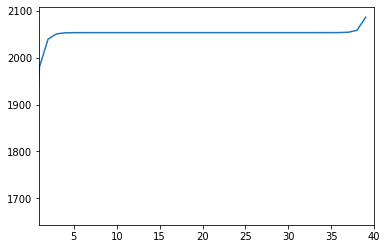

In [9]:
plt.figure()
plt.plot(mean_hours)
plt.xlim([1,40])
plt.show()

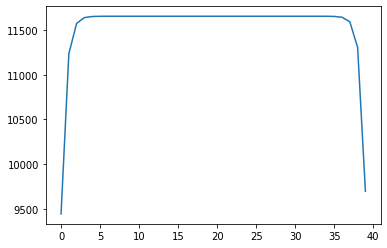

In [10]:
plt.figure()
plt.plot(mean_consumption)
plt.show()

Imposing values for the interest rate and the psychological discount factor

In [11]:
# Using Bover's estimates to calibrate the model
# Based on Table 1, Column 2 Estimates/ adjusts for risk free rate and discount factor
gamma_h = 1768.1516
gamma_c = 4454.0084
varphi = 0.2205
rho = 0.08
r = 0.02
beta_const = 0.1845
beta_children = -0.0238
num_children=1.79 #this is the mean number of children (Table A1)
B_1 = beta_const + beta_children*num_children
B_2 = 1 - B_1

sim_size=10000
T=40


factor = (1-(varphi/(1+r))**T)/(1-(varphi/(1+r)))
w1plus = Wage *factor
discount_factor = 1/(1+rho)
first_part = (1-discount_factor) / (1-discount_factor**T)
Rminus1 = 1/(1+r)
second_part = (1 - Rminus1**T) / (1-Rminus1)
lagrange_inverse = first_part*second_part * (gamma_h * w1plus - gamma_c)
h1 = gamma_h - B_1/w1plus*lagrange_inverse
c1 = gamma_c + B_2 * lagrange_inverse
df2=pd.DataFrame({'wage':Wage, 'h1':h1, 'c1':c1})

column_counter=2
for i in range(T-1):
    variable_name="h"+str(column_counter)
    previous_time="h"+str(column_counter-1)
    cons_name="c"+str(column_counter)
    column_counter+=1
    factor = (1-(varphi/(1+r))**(T-i-1))/(1-(varphi/(1+r)))
    w1plus = Wage *factor
    discount_factor = 1/(1+rho)
    first_part = (1-discount_factor) / (1-discount_factor**(T-i-1))
    Rminus1 = 1/(1+r)
    second_part = (1 - Rminus1**(T-i-1)) / (1-Rminus1)
    lagrange_inverse = first_part*second_part * (gamma_h * w1plus - gamma_c + varphi*df2[previous_time]*w1plus)
    h_next = gamma_h - B_1/w1plus*lagrange_inverse + varphi * df2[previous_time]
    cons_next = gamma_c + B_2 * lagrange_inverse
    df2[variable_name]=h_next
    df2[cons_name]=cons_next

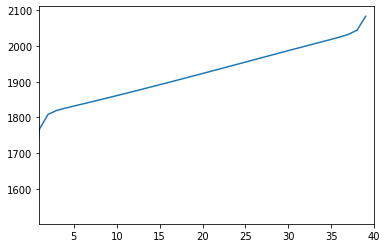

In [12]:
mean_hours2=np.zeros(T)
mean_cons2=np.zeros(T)
for i in range(T):
    j=i+1
    var_name = "h"+str(j)
    cons_name = "c"+str(j)
    mean_hours2[i]=df2[var_name].mean()
    mean_cons2[i]=df2[cons_name].mean()
    
plt.figure()
plt.plot(mean_hours2)
plt.xlim([1,40])
plt.show()

In [13]:
print(mean_hours2.mean())

1914.3220768802464


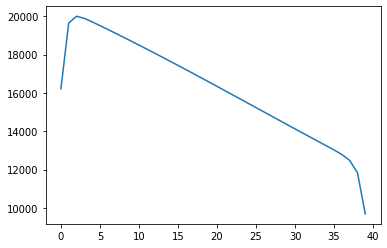

In [14]:
plt.figure()
plt.plot(mean_cons2)
plt.show()

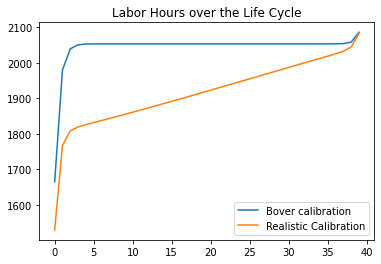

In [15]:
plt.figure()
plt.plot(mean_hours, label="Bover calibration")
plt.plot(mean_hours2, label="Realistic Calibration")
plt.legend()
plt.title('Labor Hours over the Life Cycle')
plt.show()

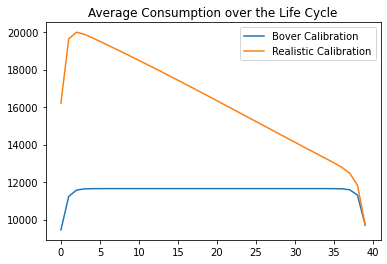

In [16]:
plt.figure()
plt.plot(mean_consumption, label="Bover Calibration")
plt.plot(mean_cons2, label="Realistic Calibration")
plt.legend()
plt.title('Average Consumption over the Life Cycle')
plt.show()

In [17]:
# Using Bover's estimates to calibrate the model
# Based on Table 1, Column 1 Estimates
#artificially imposing a lower habit values
gamma_h = 1768.1516
gamma_c = 4454.0084
varphi = 0.1
rho = 0.08
r = 0.02
beta_const = 0.1845
beta_children = -0.0238
num_children=1.79 #this is the mean number of children (Table A1)
B_1 = beta_const + beta_children*num_children
B_2 = 1 - B_1

sim_size=10000
T=40


factor = (1-(varphi/(1+r))**T)/(1-(varphi/(1+r)))
w1plus = Wage *factor
discount_factor = 1/(1+rho)
first_part = (1-discount_factor) / (1-discount_factor**T)
Rminus1 = 1/(1+r)
second_part = (1 - Rminus1**T) / (1-Rminus1)
lagrange_inverse = first_part*second_part * (gamma_h * w1plus - gamma_c)
h1 = gamma_h - B_1/w1plus*lagrange_inverse
c1 = gamma_c + B_2 * lagrange_inverse
df3=pd.DataFrame({'wage':Wage, 'h1':h1, 'c1':c1})

column_counter=2
for i in range(T-1):
    variable_name="h"+str(column_counter)
    previous_time="h"+str(column_counter-1)
    cons_name="c"+str(column_counter)
    column_counter+=1
    factor = (1-(varphi/(1+r))**(T-i-1))/(1-(varphi/(1+r)))
    w1plus = Wage *factor
    discount_factor = 1/(1+rho)
    first_part = (1-discount_factor) / (1-discount_factor**(T-i-1))
    Rminus1 = 1/(1+r)
    second_part = (1 - Rminus1**(T-i-1)) / (1-Rminus1)
    lagrange_inverse = first_part*second_part * (gamma_h * w1plus - gamma_c + varphi*df3[previous_time]*w1plus)
    h_next = gamma_h - B_1/w1plus*lagrange_inverse + varphi * df3[previous_time]
    cons_next = gamma_c + B_2 * lagrange_inverse
    df3[variable_name]=h_next
    df3[cons_name]=cons_next

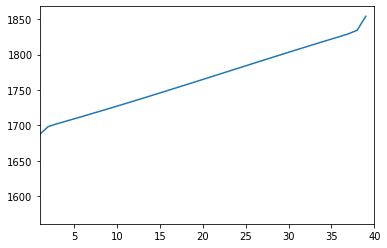

In [18]:
mean_hours3=np.zeros(T)
mean_cons3=np.zeros(T)
for i in range(T):
    j=i+1
    var_name = "h"+str(j)
    cons_name = "c"+str(j)
    mean_hours3[i]=df3[var_name].mean()
    mean_cons3[i]=df3[cons_name].mean()
    
plt.figure()
plt.plot(mean_hours3)
plt.xlim([1,40])
plt.show()

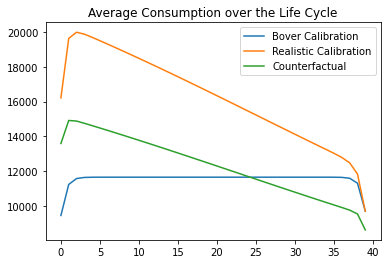

In [33]:
plt.figure()
plt.plot(mean_consumption, label="Bover Calibration")
plt.plot(mean_cons2, label="Realistic Calibration")
plt.plot(mean_cons3, label="Counterfactual")
plt.legend()
plt.title('Average Consumption over the Life Cycle')
plt.savefig('Figures/consumption_lc.png', dpi=600)
plt.show()

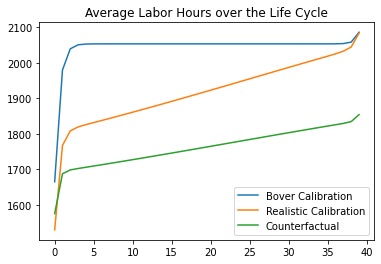

In [32]:
plt.figure()
plt.plot(mean_hours, label="Bover Calibration")
plt.plot(mean_hours2, label="Realistic Calibration")
plt.plot(mean_hours3, label='Counterfactual')
plt.legend()
plt.title('Average Labor Hours over the Life Cycle')
plt.savefig('Figures/hours_lc.png', dpi=600)
plt.show()

Let's try calculating some elasticities.
The basic elasticity given is
$$\epsilon_{it} = \frac{w}{h}\frac{\partial h}{\partial w} $$
The authors use the following approximation:
$$\epsilon = \frac{\gamma_h +\varphi h_{i,t-1}}{h_{i,t}} -1 $$

Evaluating at the sample means using the Bover calibrations, we get

In [21]:
def epsilon_calc(var, gamma_h=gamma_h, varphi=varphi):
    epsilon = (gamma_h +varphi *var[0:T-1].mean())/var.mean()-1
    return(epsilon)
def eta_alph_calc(hour_var, b1=B_1, gamma_h=gamma_h, r=r, varphi=varphi, alpha=Wage, wage=Wage):
    eta_alpha = (-1)*b1 *(gamma_h + varphi*r*hour_var[1:T-1].mean()/(1+r))*alpha.mean()/wage.mean()/hour_var.mean()
    return(eta_alpha)
#in this setting eta_delta does not matter since the wage is not changing for individuals

In [22]:
epsilon=epsilon_calc(mean_hours, varphi=0.2205)
epsilon2=epsilon_calc(mean_hours2, varphi=0.2205)
epsilon3=epsilon_calc(mean_hours3, varphi=0.1)
eta1=eta_alph_calc(mean_hours, r=0.2429, varphi=0.2205)
eta2=eta_alph_calc(mean_hours2, r=0.02, varphi=0.2205)
eta3=eta_alph_calc(mean_hours3, r=0.02, varphi=0.1)

In [23]:
epsilons = [epsilon, epsilon2, epsilon3]
etas=[eta1,eta2,eta3]
simulation=['Original', "Realistic", "Counterfactual"]
elast = pd.DataFrame({'Simulation':simulation,'epsilons':epsilons, 'etas':etas})
elast=elast.set_index('Simulation')
elast.head()

,epsilons,etas
Simulation,,
Original,0.086136,-0.128990
Realistic,0.143644,-0.131679
Counterfactual,0.104080,-0.142775


In [25]:
elast.to_latex('Tables/elast_table.tex', header=['$\epsilon$', '$\eta^{\\alpha}$'], escape=False, float_format='%.4f', label='tab:elasts', caption='Simulated Elasticities')

In [26]:
calibrations=pd.DataFrame({"Simulation":simulation, "gamma_h":[gamma_h, gamma_h, gamma_h], "gamma_c":[gamma_c, gamma_c, gamma_c],"varphi":[0.2205, 0.2205, 0.1], "rho":[0.2429, 0.08, 0.08], "r":[0.2429,0.02,0.02]})
calibrations=calibrations.set_index('Simulation')
calibrations.head()

,gamma_h,gamma_c,varphi,rho,r
Simulation,,,,,
Original,1768.1516,4454.0084,0.2205,0.2429,0.2429
Realistic,1768.1516,4454.0084,0.2205,0.0800,0.0200
Counterfactual,1768.1516,4454.0084,0.1000,0.0800,0.0200


In [30]:
calibrations.to_latex('Tables/calibration_table.tex', header=['$\gamma_h$', '$\gamma_c$', "$\\varphi$", "$\\rho$", 'r'], escape=False, float_format='%.4f', label='tab:calibs', caption='Calibrated Parameters')